In [1]:
import collections
import hashlib
import itertools
import json
import sys
from copy import deepcopy
from pathlib import Path
from time import time
from math import comb
from functools import reduce

import bokeh
import hiplot as hip
import matplotlib
import numpy as np
import pandas as pd
import pandas_bokeh
import ray
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from pymongo import MongoClient
from math import comb
from functools import reduce
import seaborn as sns

import xplogger

print(xplogger.__version__)
from xplogger.experiment_manager.record.record_list import RecordList
from xplogger.experiment_manager.store.mongo import MongoStore
from xplogger.experiment_manager.viz import bokeh as bokeh_viz
from xplogger.experiment_manager.notebook import utils as notebook_utils
from xplogger.parser.experiment import (
    Experiment,
    ExperimentSequence,
    ExperimentSequenceDict,
)
from xplogger.parser.experiment import utils as experiment_utils

sys.path.append("/private/home/sodhani/projects/abstraction_by_gating/")

from math import sqrt
from time import time

from IPython.display import JSON
from notebooks import utils, ds

0.10.0


In [2]:
%matplotlib inline
pd.set_option("plotting.backend", "pandas_bokeh")
pandas_bokeh.output_notebook()

%matplotlib inline
# pd.set_option("plotting.backend", "pandas_bokeh")
# sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
# pandas_bokeh.output_notebook()
sns.color_palette("deep")

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

Loading BokehJS ...

In [3]:
collection_name = "abstraction_by_gating"

use_record_ids = False
ray.init(num_cpus=20, ignore_reinit_error=True)

E0605 14:55:49.646861193 2230566 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0605 14:55:49.685253331 2230566 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0605 14:55:49.717160275 2230566 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{'node_ip_address': '100.97.66.230',
 'raylet_ip_address': '100.97.66.230',
 'redis_address': '100.97.66.230:26362',
 'object_store_address': '/tmp/ray/session_2022-06-05_14-55-48_437844_2230566/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-06-05_14-55-48_437844_2230566/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-06-05_14-55-48_437844_2230566',
 'metrics_export_port': 48358,
 'gcs_address': '100.97.66.230:44337',
 'node_id': 'f5e94a7e714c639e0567fd8f7c99b0ce7d571267d632d1d1c712043e'}

In [4]:
mongo_store = MongoStore(
    config={
        "host": "localhost",
        "port": 27017,
        "db": "project",
        "collection_name": collection_name,
    }
)
print(f"Num documents: {mongo_store.collection.count_documents({})}")

Num documents: 43900


In [5]:
# start_time = time()
# mongo_records = mongo_store.ray_get_records()
# print(time() - start_time)
start_time = time()
mongo_records = mongo_store.get_records(query={})
print(time() - start_time)

4.800093173980713


In [6]:
mongo_to_record = {}
issue_to_mongo_record = {}
unanalyzed_records = []
start = time()
for record in mongo_records:
    mongo_record_id = record.id
    mongo_to_record[mongo_record_id] = record
    issue_id = str(record["setup"]["git"]["issue_id"])
    if issue_id not in issue_to_mongo_record:
        issue_to_mongo_record[issue_id] = []
    issue_to_mongo_record[issue_id].append(record)
    if record["status"] != "ANALYZED":
        unanalyzed_records.append(record)

print(f"Time taken: {time() - start}")
assert len(unanalyzed_records) == len(mongo_store.get_unanalyzed_records())

Time taken: 0.17445898056030273


In [7]:
start = time()
record_list = RecordList(unanalyzed_records[:])
print(f"Total number of unanalayzed records: {len(record_list)}")
unique_issues = record_list.get_unique_issues()
print(unique_issues)
print(f"Time taken: {time() - start}")

Total number of unanalayzed records: 32475
Counter({'1': 15942, '3': 4809, '25': 2751, '4': 2304, '36': 1408, '28': 1152, '29': 1123, '22': 962, '35': 614, '3-1': 480, '121': 372, 'dummy': 220, '31': 168, '18': 158, '30': 12})
Time taken: 0.05608248710632324


In [8]:
# start = time()
record_list = []
# for issue_id in ["335", "325"]:
for issue_id in ["29"]:
    # for issue_id in issue_to_mongo_record:
    record_list += issue_to_mongo_record[issue_id]


def key_func(record):
    return record["setup"]["id"]

def filter_fn(record):
    return True
#     return record["dataloader"]["task_specific_cfgs"]["living_or_not"]["train_config"]["model"]["should_use_pretrained"]
#     return record["setup"]["script_id"] not in ["3-3", "3-4"]

print(len(record_list))
record_list = RecordList([x for x in record_list if filter_fn(x)])
# RecordList([x for x in record_list.ray_make_oc_records() if x["status"]!="ANALYZED" and "id" in x]).mark_analyzed(collection=mongo_store.collection)
slurm_id_to_record_map = record_list.map_to_slurm_id()
record_list = record_list.get_unique(key_func).ray_make_oc_records()
# print(f"Time taken: {time() - start}")
print(f"Number of selected records: {len(record_list)}")
print(
    f"Number of uniques runs: {len(set(record['setup']['id'] for record in record_list))}"
)
print(
    f"Number of unanalyzed runs: {len(set(record['setup']['id'] for record in record_list if record['status']!='ANALYZED'))}"
)
print(
    f"Set of issues: {set(record['setup']['git']['issue_id'] for record in record_list)}"
)
print(
    f"Set of script ids: {set(record['setup']['script_id'] for record in record_list)}"
)

1803
Number of selected records: 680
Number of uniques runs: 680
Number of unanalyzed runs: 0
Set of issues: {29}
Set of script ids: {29}


In [9]:
record_list.data[0].id

'6224e315051839fafbec4050'

In [10]:
record_list = RecordList(list(x for x in record_list if x.setup.script_id == 29))

# record_list.mark_analyzed(mongo_store.collection)
# RecordList([x for x in record_list.ray_make_oc_records() if x["status"]!="ANALYZED" and "id" in x]).mark_analyzed(collection=mongo_store.collection)

# record_list = RecordList(list(x for x in record_list if x.setup.script_id == "25-1"))

In [11]:
# mongo_store.collection.delete_many({"setup.id": "4092ad9e159b169d9257967ef7bb1e736bf742e7f02fabad188a650d_issue_29_seed_1"})

In [12]:
# for r in record_list:
#     model_cfg = r.model
#     if (
#         model_cfg["hidden_layer_cfg"]["dim"] == 128
#         and model_cfg["num_layers"] == 1
#         and model_cfg["weight_init"]["bias"] == 0
#         and model_cfg["weight_init"]["gain"] == 1.0
#         and model_cfg["gate_cfg"]["mode"] == "4_plus_mod"
#         #             and exp.config["experiment"]["task_one"]["transform"] == "default"
#         #             and exp.config["experiment"]["task_two"]["transform"] == "invert"
#     ):
#         print(r)
#         break

In [13]:
len(record_list)

680

In [14]:
# new_record_list = []
# for r in record_list:
#     if "optimizer._target_.optimizer.lr" in r["setup"]["viz"]["params"]:
#         new_record_list.append(r)
# new_record_list = RecordList(new_record_list)

# record_list.delete(collection=mongo_store.collection, delete_from_filesystem=False)

In [15]:
!pwd

E0605 14:56:03.662990747 2230566 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/private/home/sodhani/projects/abstraction_by_gating/notebooks


In [16]:
# record_list.delete(collection=mongo_store.collection, delete_from_filesystem=False)

In [17]:
load_experiment_from_dir = lambda log_dir: utils.load_experiment_from_dir(
    log_dir=log_dir,
    cache_failed_experiment=True,
    verbose=False,
    skip_cache=False,
)

viz_params = record_list.get_viz_params()

viz_params.remove("experiment")
start_time = time()
# (
#     exp_seq_dict,
#     groups,
#     hyperparams,
# ) = record_list.ray_make_experiment_sequence_dict_groups_and_hyperparams(
#     viz_params, load_experiment_from_dir
# )

(
    exp_seq_dict,
    groups,
    hyperparams,
) = record_list.make_experiment_sequence_dict_groups_and_hyperparams(
    viz_params, load_experiment_from_dir
)

print(f"Time taken: {time() - start_time}")


notebook_utils.prettyprint_dict(hyperparams)

Time taken: 23.562596559524536
model.pretrained_cfg.should_use
	{False}
model.weight_init.should_do
	{True}
experiment.task.num_classes_in_selected_dataset
	{10}
dataloader.train_config.dataloader.batch_size
	{8}
optimizer.lr
	{0.0001}
model.num_layers
	{1}
model.hidden_layer_cfg.dim
	{128, 1024}
experiment.task.mode
	{'permute_input_permute_target', 'rotate_input_permute_target'}
model.weight_init.gain
	{0.1, 1.0, 10.0, 0.01, 0.0001, 0.001}
setup.script_id
	{29}
model.encoder_cfg.should_share
	{False}
model.weight_init.bias
	{0}
dataloader.name
	{'mnist'}
experiment.save.frequency
	{100, 999}
experiment.num_epochs
	{10000, 1000}
model.hidden_layer_cfg.should_share
	{True}
experiment.task.num_input_transformations
	{40, 80, 60}
model.gate_cfg.mode
	{'5_plus_mod_permute', '30_plus_mod_permute', '25_plus_mod_permute', '10_plus_mod_permute', '40_plus_mod_permute', '35_plus_mod_permute', '15_plus_mod_permute', '20_plus_mod_permute'}
optimizer.momentum
	{0.9}
model.should_use_non_linearity


In [18]:
viz_params

{'dataloader.name',
 'dataloader.train_config.dataloader.batch_size',
 'experiment.num_epochs',
 'experiment.save.frequency',
 'experiment.task.mode',
 'experiment.task.num_classes_in_selected_dataset',
 'experiment.task.num_input_transformations',
 'model.decoder_cfg.should_share',
 'model.encoder_cfg.should_share',
 'model.gate_cfg.mode',
 'model.hidden_layer_cfg.dim',
 'model.hidden_layer_cfg.should_share',
 'model.num_layers',
 'model.pretrained_cfg.should_use',
 'model.should_use_non_linearity',
 'model.weight_init.bias',
 'model.weight_init.gain',
 'model.weight_init.should_do',
 'optimizer._target_',
 'optimizer.lr',
 'optimizer.momentum',
 'setup.script_id'}

In [19]:
print(list(exp_seq_dict.values())[0])
print(type(list(exp_seq_dict.values())[0]))

<class 'xplogger.parser.experiment.experiment.ExperimentSequence'>


In [20]:
exp = list(exp_seq_dict.values())[0][0]
pd.options.display.max_columns = None
pd.options.display.max_rows = None
exp.metrics["train_epoch"]

average_loss_for_selected_paths  average_loss_for_unselected_paths  \
0                            2.302610                           2.302610   
2                            2.302507                           2.302507   
4                            2.302459                           2.302459   
6                            2.302408                           2.302408   
8                            2.302362                           2.302362   
10                           2.302319                           2.302319   
12                           2.302274                           2.302274   
14                           2.302233                           2.302233   
16                           2.302200                           2.302200   
18                           2.302156                           2.302156   
20                           2.302119                           2.302119   
22                           2.302079                           2.302079   
24                           2.302045                           2.302045   
26                           2.302014                           2.302014   
28                           2.301986                           2.301986   
30                           2.301953                           2.301953   
32                           2.301924                           2.301924   
34                           2.301889                           2.301889   
36                           2.301862                           2.301862   
38                           2.301844                           2.301844   
40                           2.301812                           2.301812   
42                           2.301789                           2.301789   
44                           2.301768                           2.301768   
46                           2.301744                           2.301744   
48                           2.301725                           2.301725   
50                           2.301701                           2.301701   
52                           2.301678                           2.301678   
54                           2.301661                           2.301661   
56                           2.301648                           2.301648   
58                           2.301624                           2.301624   
60                           2.301606                           2.301606   
62                           2.301594                           2.301594   
64                           2.301576                           2.301576   
66                           2.301561                           2.301561   
68                           2.301544                           2.301544   
70                           2.301532                           2.301532   
72                           2.301517                           2.301517   
74                           2.301503                           2.301503   
76                           2.301491                           2.301491   
78                           2.301475                           2.301475   
80                           2.301467                           2.301467   
82                           2.301457                           2.301457   
84                           2.301439                           2.301439   
86                           2.301436                           2.301436   
88                           2.301422                           2.301422   
90                           2.301411                           2.301411   
92                           2.301402                           2.301402   
94                           2.301397                           2.301397   
96                           2.301385                           2.301385   
98                           2.301373                           2.301373   
100                          2.301372                           2.301372   
102                          2.301359                 

In [21]:
list(exp_seq_dict.values())[0][0].config["setup"]["viz"]

{'params': ['experiment.num_epochs',
  'experiment.task.num_input_transformations',
  'experiment.task.num_classes_in_selected_dataset',
  'dataloader.train_config.dataloader.batch_size',
  'dataloader.name',
  'experiment',
  'model.num_layers',
  'model.gate_cfg.mode',
  'model.pretrained_cfg.should_use',
  'experiment.task.mode',
  'model.hidden_layer_cfg.dim',
  'model.should_use_non_linearity',
  'model.encoder_cfg.should_share',
  'model.hidden_layer_cfg.should_share',
  'model.decoder_cfg.should_share',
  'setup.script_id',
  'model.weight_init.should_do',
  'model.weight_init.gain',
  'model.weight_init.bias',
  'optimizer._target_',
  'optimizer.lr',
  'optimizer.momentum']}

In [22]:
notebook_utils.prettyprint_dict(hyperparams)

model.pretrained_cfg.should_use
	{False}
model.weight_init.should_do
	{True}
experiment.task.num_classes_in_selected_dataset
	{10}
dataloader.train_config.dataloader.batch_size
	{8}
optimizer.lr
	{0.0001}
model.num_layers
	{1}
model.hidden_layer_cfg.dim
	{128, 1024}
experiment.task.mode
	{'permute_input_permute_target', 'rotate_input_permute_target'}
model.weight_init.gain
	{0.1, 1.0, 10.0, 0.01, 0.0001, 0.001}
setup.script_id
	{29}
model.encoder_cfg.should_share
	{False}
model.weight_init.bias
	{0}
dataloader.name
	{'mnist'}
experiment.save.frequency
	{100, 999}
experiment.num_epochs
	{10000, 1000}
model.hidden_layer_cfg.should_share
	{True}
experiment.task.num_input_transformations
	{40, 80, 60}
model.gate_cfg.mode
	{'5_plus_mod_permute', '30_plus_mod_permute', '25_plus_mod_permute', '10_plus_mod_permute', '40_plus_mod_permute', '35_plus_mod_permute', '15_plus_mod_permute', '20_plus_mod_permute'}
optimizer.momentum
	{0.9}
model.should_use_non_linearity
	{False}
optimizer._target_
	{'

In [23]:
type(list(exp_seq_dict.values())[0])

xplogger.parser.experiment.experiment.ExperimentSequence

In [24]:
%debug
# y_metric_list = ["accuracy_odd_even", "accuracy_greater_than_four"]
y_metric_list = ["average_accuracy_for_selected_paths"]
# y_metric_list = ["accuracy"]
x_metric = "epoch"
mode = "test_epoch"


def filter_fn(key, experiment_sequence):
    def filter_experiment(exp):

        if not exp:
            return False
        model_cfg = exp.config["model"]
        return (
            exp.config["experiment"]["task"]["mode"] == "permute_input_permute_target"
            and model_cfg["hidden_layer_cfg"]["dim"] == 128
            and exp.config["experiment"]["num_epochs"] == 10000
            and model_cfg["num_layers"] == 1
            and model_cfg["weight_init"]["bias"] == 0
            and model_cfg["weight_init"]["gain"] in [0.1, 0.01]
            and exp.config["optimizer"]["_target_"] == "torch.optim.SGD"
            #             and model_cfg["weight_init"]["gain"] == 0.001
            and model_cfg["gate_cfg"]["mode"] in ["5_plus_mod_permute"]
            #             and model_cfg["gate_cfg"]["mode"] in ["5_plus_mod_permute"]
            #             in ["4_plus_mod", "4_plus_mod_permute", "6_plus_mod", "6_plus_mod_permute"]
            and exp.config["experiment"]["task"]["num_classes_in_selected_dataset"]
            == 10
            #             and exp.config["model"]["hidden_layer_cfg"]["should_use_non_linearity"] == True
        )

    return all(filter_experiment(exp) for exp in experiment_sequence)


def get_function_to_get_experiment_name(param_list):
    unique_params_and_values = {}
    words_to_ignore = []
    for param in param_list:
        for key, value in param.items():
            if key not in unique_params_and_values:
                unique_params_and_values[key] = set()
            unique_params_and_values[key].add(value)
    for key, value in unique_params_and_values.items():
        if len(value) == 1:
            words_to_ignore.append(key)

    def get_experiment_name(params, **kwargs):
        return "-".join(
            [
                f"{val}"
                for key, val in sorted(
                    list((OmegaConf.to_container(params)).items())
                    + list(kwargs.items())
                )
                if all(word not in key for word in words_to_ignore)
            ]
        )
        return "-".join(
            [
                f"{val}"
                for key, val in sorted(
                    list((OmegaConf.to_container(params)).items())
                    + list(kwargs.items())
                )
                if all(word not in key for word in words_to_ignore)
            ]
        )

    return get_experiment_name


def plot(
    filter_fn,
    y_metric_list: list[str] = ["return_mean"],
    x_metric: str = "frames",
    mode: str = "train",
    metadata_for_plot={},
    p=None,
    color_palette=None,
    color_offset: int = 0,
    colors=None,
):

    filtered_exp_seq_dict = ExperimentSequenceDict(
        {
            key: ExperimentSequence(experiment_sequence)
            for key, experiment_sequence in sorted(
                exp_seq_dict.items(),
                key=lambda item: sorted(OmegaConf.to_container(item[0]).items()),
            )
            if filter_fn(key, experiment_sequence)
        }
    )

    fn_to_get_experiment_name = get_function_to_get_experiment_name(
        param_list=list(filtered_exp_seq_dict.keys())
    )

    color_palette = bokeh.palettes.d3["Category20"]

    return bokeh_viz.plot_experiment_sequence_dict(
        exp_seq_dict=filtered_exp_seq_dict,
        kwargs_for_aggregate_metrics={
            "get_experiment_name": fn_to_get_experiment_name,
            "x_name": x_metric,
            "mode": mode,
            "drop_duplicates": True,
            "dropna": True,
            "verbose": True,
            "metric_names": y_metric_list,
            "x_min": 100,
            "x_max": 10000,
        },
        metadata_for_plot=metadata_for_plot,
        color_palette=color_palette,
        p=p,
        colors=colors,
        color_offset=color_offset,
    )


title = "title"
color_palette = bokeh.palettes.d3["Category20"]
colors = color_palette[20][::1]

p = None

p = plot(
    filter_fn=filter_fn,
    metadata_for_plot={"title": title, "fill_alpha": 0.2},
    y_metric_list=y_metric_list,
    x_metric=x_metric,
    color_palette=color_palette,
    mode=mode,
    p=p,
    color_offset=0,
    colors=colors,
)

p.legend.click_policy = "hide"
# p.legend.visible=


bokeh.plotting.show(p)

ERROR:root:No traceback has been produced, nothing to debug.


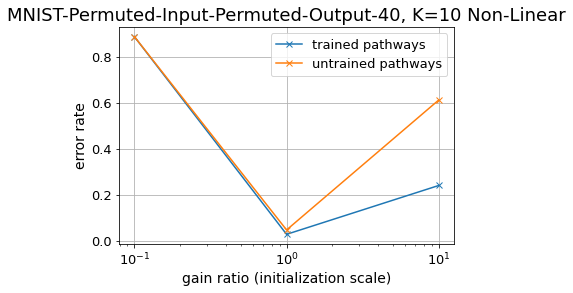

In [25]:
# param_list = list(filtered_exp_seq_dict.keys())

x = np.asarray([0.1, 1.0, 10.0])

K = 10
#permute input
data_y = {
    10: {
#         "trained": np.asarray([91.4, 92.4, 88.1]),
#         "untrained": np.asarray([91.3, 65, 37.6]),
#         "trained": np.asarray([11.3, 92.4, 87.6]),
#         "untrained": np.asarray([11.3, 81.2, 43.8]),
#         "trained": np.asarray([11.3, 92.4, 87.7]),
#         "untrained": np.asarray([11.3, 84.1, 44.2]),
#         "trained": np.asarray([11.3, 97.3, 77.6]),
#         "untrained": np.asarray([11.3, 96.9, 55.7]),
        "trained": np.asarray([11.3, 97.1, 75.9]),
        "untrained": np.asarray([11.3, 95.2, 38.8]),
    }
}

# rotate input
# data_y = {
#     10: {
#         "trained": np.asarray([91.2, 92.4, 88.1]),
#         "untrained": np.asarray([84.1, 70.3, 38.8]),
#     }
# }

for mode in ["trained", "untrained"]:
    plt.plot(x, (100 - data_y[K][mode]) / 100, label = f"{mode} pathways", marker = "x")
    
plt.ylabel("error rate")
plt.xscale('log')
plt.xlabel("gain ratio (initialization scale)")

plt.title(f"MNIST-Permuted-Input-Permuted-Output-40, K={K} Non-Linear")
plt.grid()
plt.legend()

# plt.show()

# plt.savefig(
#     f"/private/home/sodhani/projects/abstraction_by_gating/results/mnist-permute-input-40-gain-ratio-{K}-percent-128.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.clf()

In [26]:
def map_combination_to_hyperparams(combination):
    combination_dict = {}
    for key, value in zip(hyperparams.keys(), combination):
        combination_dict[key] = value
    return combination_dict

In [27]:
def make_metadata(
    mode: str,
    max_epochs: int,
    min_epochs: int,
    metric_name: str,
):
    metadata = OmegaConf.create(
        {
            "metric_name": metric_name,
            "mode": mode,
            "x": {"name": "epoch", "min": min_epochs, "max": max_epochs},
        }
    )

    step_metadata = OmegaConf.create(
        {
            "metric_name": "epoch",
            "mode": mode,
            "x": {"name": "epoch", "min": min_epochs, "max": max_epochs},
        }
    )

    return metadata, step_metadata

In [28]:
# list(exp_seq_dict.values())[0].aggregate_metrics(
#         metric_names=[metadata.metric_name],
#         x_name=metadata.x.name,
#         x_min=metadata.x.min,
#         x_max=metadata.x.max,
#         mode=metadata.mode,
#         drop_duplicates=True,
#         verbose=True,
#     )

In [29]:
type(list(exp_seq_dict.values())[0])

xplogger.parser.experiment.experiment.ExperimentSequence

In [30]:
mode = "test_epoch"
# metric_name = "accuracy_task_two_encoder_task_one_decoder"

metrics = [
    "average_accuracy_for_selected_paths",
    "average_accuracy_for_unselected_paths",
    "average_loss_for_selected_paths",
    "average_loss_for_unselected_paths",
]

df_dict = {}

for metric_name in metrics:
    metadata, step_metadata = make_metadata(
        mode=mode,
        max_epochs=10000,
        min_epochs=1,
        metric_name=metric_name,
    )

    df_dict[metric_name] = notebook_utils.make_df(
        metadata=metadata,
        step_metadata=step_metadata,
        groups=groups,
        hyperparams=hyperparams,
        exp_seq_dict=exp_seq_dict,
    )
    
#     df_dict[key].drop(
#         [],
#         axis=1,
#         inplace=True,
#     )

In [31]:
df_dict["average_accuracy_for_unselected_paths"]

model.pretrained_cfg.should_use  model.weight_init.should_do  \
0                              False                         True   
1                              False                         True   
2                              False                         True   
3                              False                         True   
4                              False                         True   
5                              False                         True   
6                              False                         True   
7                              False                         True   
8                              False                         True   
9                              False                         True   
10                             False                         True   
11                             False                         True   
12                             False                         True   
13                             False                         True   
14                             False                         True   
15                             False                         True   
16                             False                         True   
17                             False                         True   
18                             False                         True   
19                             False                         True   
20                             False                         True   
21                             False                         True   
22                             False                         True   
23                             False                         True   
24                             False                         True   
25                             False                         True   
26                             False                         True   
27                             False                         True   
28                             False                         True   
29                             False                         True   
30                             False                         True   
31                             False                         True   
32                             False                         True   
33                             False                         True   
34                             False                         True   
35                             False                         True   
36                             False                         True   
37                             False                         True   
38                             False                         True   
39                             False                         True   
40                             False                         True   
41                             False                         True   
42                             False                         True   
43                             False                         True   
44                             False                         True   
45                             False                         True   
46                             False                         True   
47                             False                         True   
48                             False                         True   
49                             False                         True   
50                             False                         True   
51                             False                         True   
52                             False                         True   
53                             False                         True   
54                             False                         True   
55                             False                         True   
56                             False                         True   
57 

In [32]:
keys_to_merge_on = [
    "model.hidden_layer_cfg.dim",
    "experiment.task.num_classes_in_selected_dataset",
    "experiment.num_epochs",
    "dataloader.name",
    "model.decoder_cfg.should_share",
    "model.weight_init.bias",
    "experiment.task.mode",
    "model.num_layers",
    "optimizer._target_",
    "setup.script_id",
    "model.weight_init.gain",
    "model.weight_init.should_do",
    "model.encoder_cfg.should_share",
    "experiment.task.num_input_transformations",
    "optimizer.lr",
    "optimizer.momentum",
    "model.should_use_non_linearity",
    "model.gate_cfg.mode",
    "dataloader.train_config.dataloader.batch_size",
    "model.pretrained_cfg.should_use",
    "model.hidden_layer_cfg.should_share",
    "steps",
    "seeds",
    "experiment.save.frequency",
]

merged_df = df_dict[metrics[0]]
for current_metric in metrics[1:]:
    merged_df = merged_df.merge(
        df_dict[current_metric], on=keys_to_merge_on, suffixes=[None, None]
    )

merged_df = merged_df.drop(
    [
        "seeds",
#         "steps",
#         "experiment.name",
#         "experiment.task.num_classes_in_original_dataset",
#         "model.gate_cfg.mode",
#         "experiment.num_epochs",
        "mean_average_loss_for_unselected_paths",
        "mean_average_loss_for_selected_paths",
        "experiment.save.frequency",
    ]
    + [f"stderr_{metric_name}" for metric_name in metrics],
    axis=1,
)

merged_df.style.set_sticky(axis="columns")

merged_df

# import seaborn as sns

# cm = sns.light_palette("red", as_cmap=True)

# merged_df.style.background_gradient(
#     axis=1, subset=[f"mean_return_mean_{key}" for key in keys], vmax=1.4, vmin=0.6
# )

model.pretrained_cfg.should_use  model.weight_init.should_do  \
0                              False                         True   
1                              False                         True   
2                              False                         True   
3                              False                         True   
4                              False                         True   
5                              False                         True   
6                              False                         True   
7                              False                         True   
8                              False                         True   
9                              False                         True   
10                             False                         True   
11                             False                         True   
12                             False                         True   
13                             False                         True   
14                             False                         True   
15                             False                         True   
16                             False                         True   
17                             False                         True   
18                             False                         True   
19                             False                         True   
20                             False                         True   
21                             False                         True   
22                             False                         True   
23                             False                         True   
24                             False                         True   
25                             False                         True   
26                             False                         True   
27                             False                         True   
28                             False                         True   
29                             False                         True   
30                             False                         True   
31                             False                         True   
32                             False                         True   
33                             False                         True   
34                             False                         True   
35                             False                         True   
36                             False                         True   
37                             False                         True   
38                             False                         True   
39                             False                         True   
40                             False                         True   
41                             False                         True   
42                             False                         True   
43                             False                         True   
44                             False                         True   
45                             False                         True   
46                             False                         True   
47                             False                         True   
48                             False                         True   
49                             False                         True   
50                             False                         True   
51                             False                         True   
52                             False                         True   
53                             False                         True   
54                             False                         True   
55                             False                         True   
56                             False                         True   
57 

In [33]:
df_to_plot = merged_df

# keys_to_drop = ["model.should_share_hidden_layer", "model.name", "model.should_share_decoder", 
#                 "stderr_accuracy_greater_than_four_encoder_odd_even_decoder", 
#                 "steps", "seeds", 
#                 "model.num_layers", "model.weight_init.should_do", 
#                 "model.should_share_encoder", "model.hidden_size"
#                ]
# df_to_plot = df_to_plot.drop(keys_to_drop, axis=1)

hip.Experiment.from_dataframe(df_to_plot).display()



<IPython.core.display.Javascript object>

In [34]:
# experiment.task.num_input_transformations
# 	{40, 80, 60}
# optimizer._target_
# 	{'torch.optim.SGD'}
# optimizer.momentum
# 	{0.9}
# dataloader.name
# 	{'mnist'}
# model.weight_init.gain
# 	{0.1, 1.0, 10.0, 0.01, 0.0001, 0.001}
# experiment.task.mode
# 	{'rotate_input_permute_target', 'permute_input_permute_target'}
# optimizer.lr
# 	{0.0001}
# dataloader.train_config.dataloader.batch_size
# 	{8}
# model.should_use_non_linearity
# 	{False}
# model.weight_init.bias
# 	{0}
# model.num_layers
# 	{1}
# setup.script_id
# 	{29}
# experiment.save.frequency
# 	{100, 999}
# model.encoder_cfg.should_share
# 	{False}
# model.decoder_cfg.should_share
# 	{False}
# model.gate_cfg.mode
# 	{'40_plus_mod_permute', '20_plus_mod_permute', '5_plus_mod_permute', '15_plus_mod_permute', '10_plus_mod_permute', '25_plus_mod_permute', '30_plus_mod_permute', '35_plus_mod_permute'}
# model.hidden_layer_cfg.should_share
# 	{True}
# model.weight_init.should_do
# 	{True}
# model.pretrained_cfg.should_use
# 	{False}

IndentationError: unexpected indent (2778269899.py, line 2)